## Notebook to plot the results of the fitting routine tests vs the same results for WFC3

In [1]:
import matplotlib.pyplot as plt
import pickle, bz2
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

%matplotlib notebook

#### Setup cell

In [2]:
dirsave = '/user/gennaro/Functional_work/Up_the_ramp_myfork/Simulations_results/'
testname = 'STEP200_NSAMP13_SNR50_CR6'

In [3]:
outputs_file = dirsave+'Test_'+testname+'_out.pbz2'
inputs_file  = dirsave+'Test_'+testname+'_in.pbz2'
calwf3out_file = dirsave+'Test_'+testname+'_in.JSON'

#### Restore the saved files and prepare all variables

In [4]:
with bz2.BZ2File(outputs_file, 'rb') as f:
    dictoload = pickle.load(f)

goodints_l        =  dictoload['goodints_l']
counter_l         =  dictoload['counter_l']
error_l           =  dictoload['error_l']
crloops_counter_l =  dictoload['crloops_counter_l']
outerate_l        =  dictoload['outerate_l']
gof_stat_l        =  dictoload['gof_stat_l']
gof_pval_l        =  dictoload['gof_pval_l']


with bz2.BZ2File(inputs_file, 'rb') as f:
    dictoload = pickle.load(f)

meas_l     = dictoload['meas_l']
myfluxes   = dictoload['myfluxes']
myramps    = dictoload['myramps']
myCRrates  = dictoload['myCRrates']
mybgs      = dictoload['mybgs']
CRdict_l   = dictoload['CRdict_l']
extra_bg_l = dictoload['extra_bg_l']

del(dictoload)

#Unpack the lists to regroup items by ramp

ntest = len(meas_l)//len(myramps)

gi_list  = [np.empty([ntest,mm.group_times.size-1],dtype=np.bool_) for mm in myramps]
CR_list   = [[[] for _ in range(ntest)] for mm in myramps]
meas_list = [[[] for _ in range(ntest)] for mm in myramps]
ebg_list  = [[[] for _ in range(ntest)] for mm in myramps]

counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
error    = np.empty([ntest,len(myfluxes)],dtype=np.int_)
outerate = np.empty([ntest,len(myfluxes)])
crloops_counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
gof_stat = np.empty([ntest,len(myfluxes)])
gof_pval = np.empty([ntest,len(myfluxes)])

for l,(g,C,m,c,e,cc,o,gs,gp,eb) in enumerate(zip(goodints_l,CRdict_l,meas_l,counter_l,error_l,crloops_counter_l,outerate_l,gof_stat_l,gof_pval_l,extra_bg_l)):

    k = l % ntest
    j = l // ntest
    
    counter[k,j]  = c
    error[k,j]    = e
    crloops_counter[k,j] = cc
    outerate[k,j] = o
    gof_stat[k,j] = gs
    gof_pval[k,j] = gp

    gi_list[j][k,:] = g
    CR_list[j][k]   = C
    meas_list[j][k] = m
    ebg_list[j][k]  = eb
    


#### Restore calwf3 results

In [5]:
#Note, we put the df in a list to conform with the multiple-ramps mode for the non-calwf3 experiments

calwf3df = [pd.read_json(calwf3out_file)]
calwf3df[0].head()

,FLT_ERR_VALUE,FLT_PIXEL_VALUE,TRUTH_VALUE
0,0.058262,2.748812,"[True, True, True, True, True, True, True, Tru..."
1,0.072623,2.411419,"[True, True, True, True, True, True, True, Tru..."
2,0.063214,2.530187,"[True, True, True, True, True, True, True, Tru..."
3,0.055150,2.549883,"[True, True, True, True, True, True, True, Tru..."
4,0.091512,3.709049,"[True, True, True, True, True, True, True, Tru..."


#### Regroup all the simulated CRhits and check whether they have been detected

In [6]:
allCRtimes = []
allCRcounts = []
allCRdetect = []
allCRdetect_C3 = []

ramps_with_CRs = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):

    allCRtimes_p = []
    allCRcounts_p = []
    allCRdetect_p = []
    allCRdetect_C3_p = []
    ramps_with_CRs_p = np.zeros(len(CR_list[j]),dtype=np.bool_)
    
    CRlist_p = CR_list[j]
    for i,dd in enumerate(CRlist_p):
        if dd is not None:
            ramps_with_CRs_p[i] = True
            allCRtimes_p.extend(dd['times'])
            allCRcounts_p.extend(dd['counts'])
            for t in dd['times']:
                hit_intv_idx = np.nonzero(myramp.group_times <= t)[0][-1]
                if gi_list[j][i,hit_intv_idx] ==  False:
                    allCRdetect_p.append(True)
                else:
                    allCRdetect_p.append(False)

                if calwf3df[j].loc[i,'TRUTH_VALUE'][hit_intv_idx] ==  False:
                    allCRdetect_C3_p.append(True)
                else:
                    allCRdetect_C3_p.append(False)

                    
            
    
    #print(allCRcounts_p)
    #print(allCRtimes_p)
    allCRtimes.append(np.asarray(allCRtimes_p))
    allCRcounts.append(np.asarray(allCRcounts_p))
    allCRdetect.append(np.asarray(allCRdetect_p))
    allCRdetect_C3.append(np.asarray(allCRdetect_C3_p))
    
    ramps_with_CRs.append(ramps_with_CRs_p)


#### Look for false positives in the detected CRhits

In [7]:
CR_false_positives = []
CR_false_positives_C3 = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    CR_false_positives_p = np.zeros_like(gi_list[j],dtype=np.bool_)
    CR_false_positives_p_C3 = np.zeros_like(gi_list[j],dtype=np.bool_)
    print('*************')
    print(myflux,myramp.ngroups)
    for i in range(ntest):
        detected_CR_idx = np.nonzero(~gi_list[j][i,:])[0]
        ndet = len(detected_CR_idx)
        if ndet > 0:
            CRdict  = CR_list[j][i]
            for k in range(ndet):
                if CRdict is None:
                    CR_false_positives_p[i,detected_CR_idx[k]] = True
                else:   
                    ts = myramp.group_times[detected_CR_idx[k]]
                    te = myramp.group_times[detected_CR_idx[k]+1]
                    if np.all( (CRdict['times']< ts) | ((CRdict['times']> te))) == True:
                        CR_false_positives_p[i,detected_CR_idx[k]] = True

        detected_CR_idx_C3 = np.nonzero(~np.asarray((calwf3df[j].loc[i,'TRUTH_VALUE'][:])))[0]
        ndet_C3 = len(detected_CR_idx_C3)
        if ndet_C3 > 0:
            CRdict  = CR_list[j][i]
            for k in range(ndet_C3):
                if CRdict is None:
                    CR_false_positives_p_C3[i,detected_CR_idx_C3[k]] = True
                else:   
                    ts = myramp.group_times[detected_CR_idx_C3[k]]
                    te = myramp.group_times[detected_CR_idx_C3[k]+1]
                    if np.all( (CRdict['times']< ts) | ((CRdict['times']> te))) == True:
                        CR_false_positives_p_C3[i,detected_CR_idx_C3[k]] = True

                        
    print('FP_new',np.sum(CR_false_positives_p))       
    CR_false_positives.append(CR_false_positives_p)
    print('FP_C3',np.sum(CR_false_positives_p_C3))       
    CR_false_positives_C3.append(CR_false_positives_p_C3)
    

*************
2.5 13
FP_new 3
FP_C3 4


### Diagnostic plots

#### Global diagnostics

In [8]:
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [9]:
#Plots for the GENERAL case

MD rng: [2.46424913 2.54939013]
MD resolution: 0.0008514099987632706


<IPython.core.display.Javascript object>


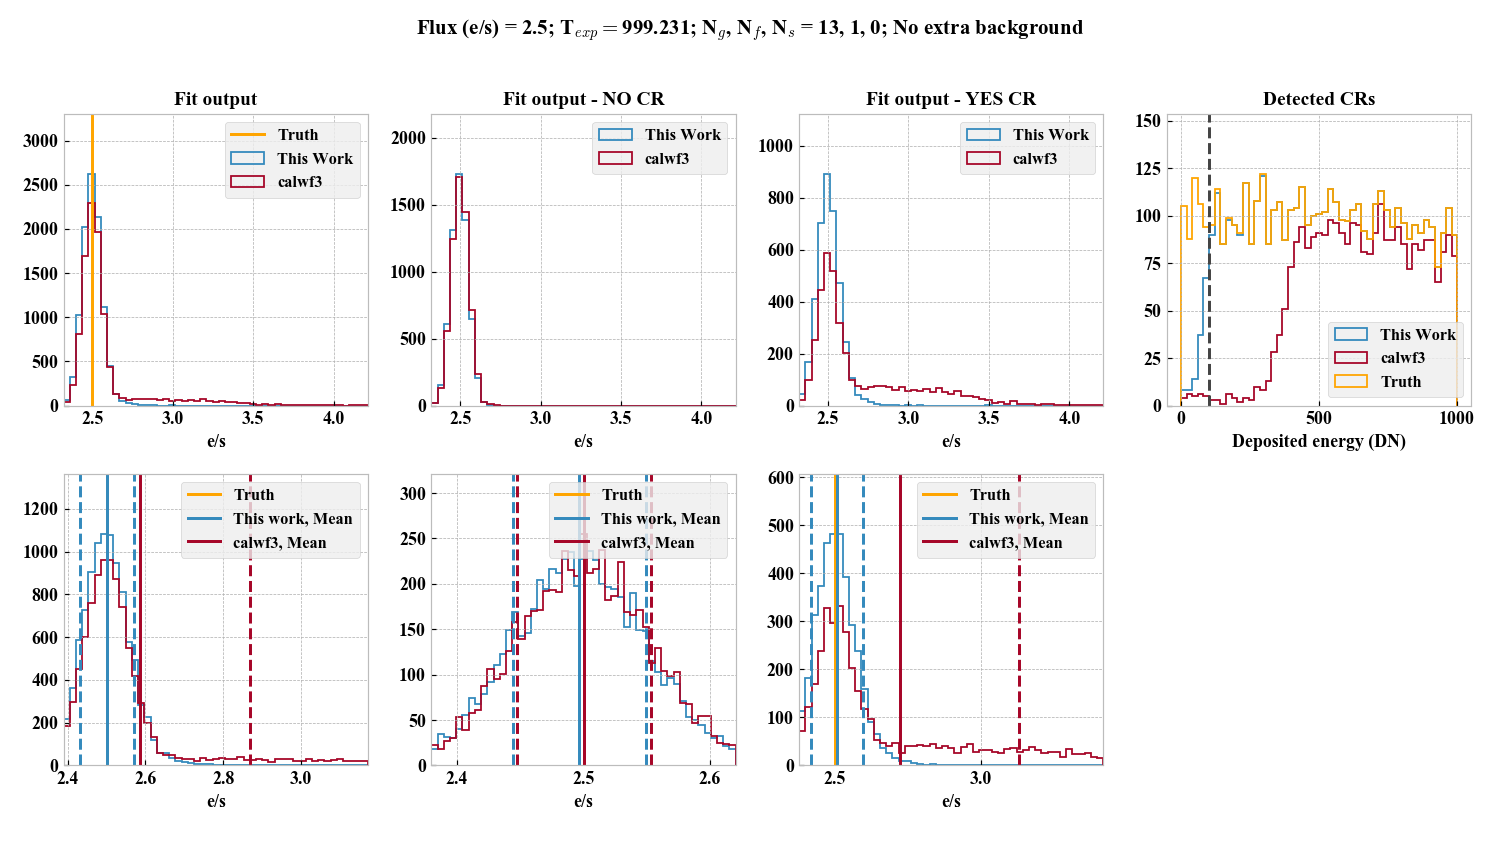

H range:  2.320577568264839 4.212770394083359
H range:  2.3898507730264584 3.1706224083749994
H range:  2.3795781230959996 2.6204368186040004
H range:  2.378979383010716 3.419215226144998


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:231: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


######################
Input flux (e/s): 2.5
Exposure time 999.231
Number of groups / frames / skips: 13 / 1 / 0
Number of tests: 10000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  2.001,  0.234,  0.007,   2.01
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0500,  0.0059,  0.0002,  0.0504
Standard deviation from "noiseless" counts (e/s):  0.0498
Standard deviation from "noisy" counts (e/s):  0.0540
 
Output mean (e/s):  2.5006 [new] /  2.5867 [calwf3]
Output median (e/s):  2.4981 [new] /  2.5125 [calwf3]
Output mode (e/s):  2.4834 [new] /  2.4979 [calwf3]
Output standard deviation (e/s):  0.0693 [new] /  0.2806 [calwf3]
Rel. % error: :  2.77 [new] / 11.23 [calwf3]
Rel. % bias::  0.02 [new] /  3.47 [calwf3]
 
no-CR Output mean (e/s):  2.4968 [new] /  2.5003 [calwf3]
no-CR Output median (e/s):  2.4966 [new] /  2.5000 [calwf3]
no-CR Output mode (e/s):  2.4987 [new] /  2.5158 [c

In [10]:
lw=1.2

colT = 'orange'
colW = '#A60628'
colN = '#348ABD'

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    
    BM0 = (error[:,j] == 0) #& (counter[:,j] > 15)
    mn = np.mean(outerate[BM0,j])
    md = np.median(outerate[BM0,j])
    st = np.std(outerate[BM0,j])

    C3_out = calwf3df[j]['FLT_PIXEL_VALUE'].values
    mn_C3 = np.mean(C3_out)
    md_C3 = np.median(C3_out)
    st_C3 = np.std(C3_out)

    vall = np.hstack([outerate[BM0,j],C3_out])
    
    mode_rng = np.percentile(vall, (25, 75))
    mode_bins=100
    print('MD rng:',mode_rng)
    print('MD resolution:',(mode_rng[1]-mode_rng[0])/mode_bins)
    
    f = plt.figure(figsize=(14,8))
    
#    minbin = md_C3-3*st_C3#np.min(np.hstack([outerate[BM0,j],C3_out]))
#    maxbin = md_C3+4*st_C3#np.max(np.hstack([outerate[BM0,j],C3_out]))
    minbin,maxbin = np.percentile(vall, (.15,99.85))
    print('H range: ',minbin,maxbin)
    
    nbh = 50
    
    ax1 = f.add_subplot(2,4,1)
    n,b,p = ax1.hist(outerate[BM0,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='This Work',linewidth=lw)
    ax1.hist(C3_out,bins=b,histtype='step',label='calwf3',linewidth=lw)

    h,b = np.histogram(outerate[BM0,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out, bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode_C3 = 0.5*(b[imode]+b[imode+1])
    
    ax1.axvline(myflux,color='orange',label='Truth')
    
    ax1.set_title('Fit output',fontsize=13)
    ax1.set_xlabel('e/s')
    ax1.legend()
    ax1.set_xlim(minbin,maxbin)

    ######################################################
    
    rCRs = ramps_with_CRs[j]
    BM2 = BM0 & (~rCRs)
    mn2 = np.mean(outerate[BM2,j])
    md2 = np.median(outerate[BM2,j])
    st2 = np.std(outerate[BM2,j])
    
    mn2_C3 = np.mean(C3_out[~rCRs])
    md2_C3 = np.median(C3_out[~rCRs])
    st2_C3 = np.std(C3_out[~rCRs])

    h,b = np.histogram(outerate[BM2,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode2 = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out[~rCRs], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode2_C3 = 0.5*(b[imode]+b[imode+1])

    
    ax2 = f.add_subplot(2,4,2)
    n,b,p = ax2.hist(outerate[BM2,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='This Work',linewidth=lw)
    ax2.hist(C3_out[~rCRs],bins=b,histtype='step',label='calwf3',linewidth=lw)    
    
    ax2.set_title('Fit output - NO CR',fontsize=13)
    ax2.set_xlabel('e/s')
    ax2.legend()
    ax2.set_xlim(minbin,maxbin)

      ######################################################
   
    BM3 = BM0 & rCRs
    mn3 = np.mean(outerate[BM3,j])
    md3 = np.median(outerate[BM3,j])
    st3 = np.std(outerate[BM3,j])

    mn3_C3 = np.mean(C3_out[rCRs])
    md3_C3 = np.median(C3_out[rCRs])
    st3_C3 = np.std(C3_out[rCRs])

    h,b = np.histogram(outerate[BM3,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode3 = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out[rCRs], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode3_C3 = 0.5*(b[imode]+b[imode+1])


    h,b = np.histogram(outerate[BM0,j], bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode = 0.5*(b[imode]+b[imode+1])

    h,b = np.histogram(C3_out, bins=mode_bins, range=mode_rng)    
    imode = np.argmax(h)
    mode_C3 = 0.5*(b[imode]+b[imode+1])

    ax3 = f.add_subplot(2,4,3)
    n,b,p = ax3.hist(outerate[BM3,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',label='This Work',linewidth=lw)
    ax3.hist(C3_out[rCRs],bins=b,histtype='step',label='calwf3',linewidth=lw)

#    ax3.axvline(myflux,color='orange',label='True')
#    ax3.axvline(mode3,color='b',label='New, Mode')
#    ax3.axvline(mn3-st3,color='b',linestyle='--')
#    ax3.axvline(mn3+st3,color='b',linestyle='--')
#    ax3.axvline(mode3_C3,color='r',label='calwf3, Mode')
#    ax3.axvline(mn3_C3-st3_C3,color='r',linestyle='--')
#    ax3.axvline(mn3_C3+st3_C3,color='r',linestyle='--')
    #ax1.axvline(md,color='black',label='New, Median')
    
    
    ax3.set_title('Fit output - YES CR',fontsize=13)
    ax3.set_xlabel('e/s')
    ax3.legend()
    ax3.set_xlim(minbin,maxbin)
    
    
    ######################################################
    ax4 = f.add_subplot(2,4,4)
    if allCRcounts[j].size >0 :
        b=np.linspace(0,1001,50)
        if allCRdetect[j].size >0 :
            n,b,p = ax4.hist(allCRcounts[j][allCRdetect[j]],bins=b,histtype='step',label='This Work',linewidth=lw)
        if allCRdetect_C3[j].size >0 :
            n,b,p = ax4.hist(allCRcounts[j][allCRdetect_C3[j]],bins=b,histtype='step',label='calwf3',linewidth=lw)
        n,b,p = ax4.hist(allCRcounts[j],bins=b,histtype='step',label='Truth',linewidth=lw,color=colT)
    
    if testname[-3:] == 'CR6':
        mult = 6.
    else:
        mult = 4.
    ax4.axvline(mult*np.sqrt(myflux*np.mean(myramp.group_times[1:]-myramp.group_times[:-1])+2*np.square(meas_list[j][0].RON_adu)),color='#444444',linestyle='--')
    
    ax4.set_title('Detected CRs',fontsize=13)
    ax4.set_xlabel('Deposited energy (DN)')
    ax4.legend(loc=4)

    ######################################################
    ######################################################
    minbin,maxbin = np.percentile(vall, (2.5,97.5))
    print('H range: ',minbin,maxbin)
    
    nbh = 50
    
    ax5 = f.add_subplot(2,4,5)
    n,b,p = ax5.hist(outerate[BM0,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',linewidth=lw)
    ax5.hist(C3_out,bins=b,histtype='step',linewidth=lw)

    
    ax5.axvline(myflux,color=colT,label='Truth')
    ax5.axvline(mn,color=colN,label='This work, Mean')
    ax5.axvline(mn-st,color=colN,linestyle='--')
    ax5.axvline(mn+st,color=colN,linestyle='--')
    ax5.axvline(mn_C3,color=colW,label='calwf3, Mean')
    ax5.axvline(mn_C3-st_C3,color=colW,linestyle='--')
    ax5.axvline(mn_C3+st_C3,color=colW,linestyle='--')
    
    
    ax5.set_xlabel('e/s')
    ax5.legend()
    
    ax5.set_xlim(minbin,maxbin)

     ######################################################
    vall = np.hstack([outerate[BM2,j],C3_out[~rCRs]])
    minbin,maxbin = np.percentile(vall, (1,99.))
    print('H range: ',minbin,maxbin)

    ax6 = f.add_subplot(2,4,6)
    n,b,p = ax6.hist(outerate[BM2,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',linewidth=lw)
    ax6.hist(C3_out[~rCRs],bins=b,histtype='step',linewidth=lw)    

    ax6.axvline(myflux,color=colT,label='Truth')
    ax6.axvline(mn2,color=colN,label='This work, Mean')
    ax6.axvline(mn2-st2,color=colN,linestyle='--')
    ax6.axvline(mn2+st2,color=colN,linestyle='--')
    ax6.axvline(mn2_C3,color=colW,label='calwf3, Mean')
    ax6.axvline(mn2_C3-st2_C3,color=colW,linestyle='--')
    ax6.axvline(mn2_C3+st2_C3,color=colW,linestyle='--')

    ax6.set_xlabel('e/s')
    ax6.legend()
    ax6.set_xlim(minbin,maxbin)

    ######################################################
    vall = np.hstack([outerate[BM3,j],C3_out[rCRs]])
    minbin,maxbin = np.percentile(vall, (2.5,97.5))
    print('H range: ',minbin,maxbin)
   
    ax7 = f.add_subplot(2,4,7)
    n,b,p = ax7.hist(outerate[BM3,j],bins=np.linspace(minbin,maxbin,nbh),histtype='step',linewidth=lw)
    ax7.hist(C3_out[rCRs],bins=b,histtype='step',linewidth=lw)

    ax7.axvline(myflux,color=colT,label='Truth')
    ax7.axvline(mn3,color=colN,label='This work, Mean')
    ax7.axvline(mn3-st3,color=colN,linestyle='--')
    ax7.axvline(mn3+st3,color=colN,linestyle='--')
    ax7.axvline(mn3_C3,color=colW,label='calwf3, Mean')
    ax7.axvline(mn3_C3-st3_C3,color=colW,linestyle='--')
    ax7.axvline(mn3_C3+st3_C3,color=colW,linestyle='--')

    ax7.set_xlabel('e/s')
    ax7.legend()
    ax7.set_xlim(minbin,maxbin)

    
    pthr = 0.1
    BMpt = gof_pval[:,j] > pthr

    BM1 = BM0 & BMpt
    mn1 = np.mean(outerate[BM1,j])
    md1 = np.median(outerate[BM1,j])
    st1 = np.std(outerate[BM1,j])

    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
        ax.set_axis_bgcolor('#FFFFFF')
        ax.set_ylim(ax.get_ylim()[0],1.2*ax.get_ylim()[1])    
    
    sts = sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{g}}$, N$_{{f}}$, N$_{{s}}$ = {}, {}, {}; No extra background'.format(myflux,
                                                                                                                               myramp.group_times[-1],
                                                                                                                               myramp.ngroups,
                                                                                                                               myramp.nframes,
                                                                                                                               myramp.nskips)
    f.suptitle(sts, fontsize=14)
    f.tight_layout(rect=[0,0.03,1,.92])

    f.savefig('/user/gennaro/Functional_work/WFC3/ISRs/Up_the_ramp_fitting/Figs/Test_'+testname+'_diagnostic_plots_'+str(j)+'.pdf') 
    
    actual_counts = np.empty(len(meas_list[j]))
    noisy_counts = np.empty(len(meas_list[j]))
    for k in range(actual_counts.size):
        actual_counts[k] = meas_list[j][k].noiseless_counts[-1]
        noisy_counts[k] = meas_list[j][k].noisy_counts[-1] - meas_list[j][k].cum_CR_counts[-1] - meas_list[j][k].noisy_counts[0]
    
    
    exptime = myramp.group_times[-1] - myramp.group_times[0] 
    mean_signal = myflux * exptime
    poi_err = np.sqrt(mean_signal)
    act_poi_err = np.std(actual_counts)*meas_list[j][0].gain
    noisy_counts_err = np.std(noisy_counts)*meas_list[j][0].gain
    
    eff_RON = meas_list[j][0].effRON_e
    eff_qerr = np.sqrt(meas_list[j][0].gain*myramp.nframes/12) * eff_RON/meas_list[j][0].RON_e

    tot_noise = np.sqrt(np.sum(np.square(np.array([poi_err,eff_RON,eff_qerr]))))


    ds = {'exptime':exptime,
          'myflux':myflux,
          'mean_signal':mean_signal,
          'poi_err':poi_err,
          'eff_RON':eff_RON,
          'eff_qerr':eff_qerr,
          'tot_noise':tot_noise,
          'act_poi_err':act_poi_err,
          'noisy_counts_err':noisy_counts_err,
          'mn':mn,
          'md':md,
          'mode':mode,
          'st':st,
          'mn_C3':mn_C3,
          'md_C3':md_C3,
          'mode_C3':mode_C3,
          'st_C3':st_C3,
          'mn2':mn2,
          'md2':md2,
          'mode2':mode2,
          'st2':st2,
          'mn2_C3':mn2_C3,
          'md2_C3':md2_C3,
          'mode2_C3':mode2_C3,
          'st2_C3':st2_C3,
          'mn3':mn3,
          'md3':md3,
          'mode3':mode3,
          'st3':st3,
          'mn3_C3':mn3_C3,
          'md3_C3':md3_C3,
          'mode3_C3':mode3_C3,
          'st3_C3':st3_C3,
          'FP_CR':np.sum(CR_false_positives[j]),
          'FP_CR_C3':np.sum(CR_false_positives_C3[j]),
          'FN_CR':len(allCRcounts[j])-np.sum(allCRdetect[j]),
          'FN_CR_C3':len(allCRcounts[j])-np.sum(allCRdetect_C3[j]),
          'True_CR_number':len(allCRcounts[j]),
          'CR_det':np.sum(allCRdetect[j]),
          'CR_det_C3':np.sum(allCRdetect_C3[j])
         }
    
    with bz2.BZ2File('/user/gennaro/Functional_work/WFC3/ISRs/Up_the_ramp_fitting/Table_data/Test_'+testname+'_tabledata_'+str(j)+'.pbz2', 'w') as f:
        pickle.dump(ds,f)
    
    print('######################')
    print('Input flux (e/s):',myflux)
    print('Exposure time',exptime)
    print('Number of groups / frames / skips: {} / {} / {}'.format(myramp.ngroups,myramp.nframes,myramp.nskips))
    print('Number of tests:',ntest)
    print('Fraction of good fits:',100.*BM0.sum().astype(np.float_)/ntest,'%')
    print(' ')    
    print('Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: {:6.3f}, {:6.3f}, {:6.3f}, {:6.3}'.format(
        100.*poi_err/mean_signal, 100.*eff_RON/mean_signal, 100.*eff_qerr/mean_signal, 100*tot_noise/mean_signal))
    print('Pure Poisson / eff. RON / eff. quantization error / total error [e/s]: {:7.4f}, {:7.4f}, {:7.4f}, {:7.4f}'.format(
        poi_err/exptime, eff_RON/exptime, eff_qerr/exptime, tot_noise/exptime))
    print('Standard deviation from "noiseless" counts (e/s): {:7.4f}'.format(act_poi_err/exptime))
    print('Standard deviation from "noisy" counts (e/s): {:7.4f}'.format(noisy_counts_err/exptime))
    print(' ')
    print('Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn,mn_C3))
    print('Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md,md_C3))
    print('Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode,mode_C3))
    print('Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st,st_C3))
    print('Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st/myflux,100.*st_C3/myflux))
    print('Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn-myflux)/myflux,100*(mn_C3-myflux)/myflux))
    print(' ')
    print('no-CR Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn2,mn2_C3))
    print('no-CR Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md2,md2_C3))
    print('no-CR Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode2,mode2_C3))
    print('no-CR Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st2,st2_C3))
    print('no-CR Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st2/myflux,100.*st2_C3/myflux))
    print('no-CR Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn2-myflux)/myflux,100*(mn2_C3-myflux)/myflux))
    print(' ')
    print('yes-CR Output mean (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mn3,mn3_C3))
    print('yes-CR Output median (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(md3,md3_C3))
    print('yes-CR Output mode (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(mode3,mode3_C3))
    print('yes-CR Output standard deviation (e/s): {:7.4f} [new] / {:7.4f} [calwf3]'.format(st3,st3_C3))
    print('yes-CR Rel. % error: : {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*st3/myflux,100.*st3_C3/myflux))
    print('yes-CR Rel. % bias:: {:5.2f} [new] / {:5.2f} [calwf3]'.format(100.*(mn3-myflux)/myflux,100*(mn3_C3-myflux)/myflux))
    print(' ')
    print('Fraction of good fits at {:6.3f} confidence: {} %'.format(pthr,100.*np.sum(BMpt)/len(BMpt)))
    print('p-flagged Output mean (e/s) {:7.4f}'.format(mn1))
    print('p-flagged Output median (e/s) {:7.4f}'.format(md1))
    print('p-flagged Output standard deviation (e/s) {:7.4f}'.format(st1))
    print('p-flagged Rel. % error: {:5.2f}'.format(100.*st1/myflux))
    print('p-flagged Rel. % bias: {:5.2f}'.format(100.*(mn1-myflux)/myflux))
    print(' ')
    print('CR hits / detected [new]',len(allCRcounts[j]),'/',np.sum(allCRdetect[j]))
    print('CR - false positives [new]',np.sum(CR_false_positives[j]))
    print('CR hits / detected [calwf3]',len(allCRcounts[j]),'/',np.sum(allCRdetect_C3[j]))
    print('CR - false positives [calwf3]',np.sum(CR_false_positives_C3[j]))
    

### Extra checks for false positive cases

In [11]:
CRnum = np.empty(len(CR_list[j]))
for i,CRdict in enumerate(CR_list[0]):
    if CRdict is None:
        CRnum[i] = 0
    else:
        CRnum[i] = len(CRdict['times'])

In [12]:
for i,C in enumerate(CR_false_positives_p):
    if (np.sum(C) > 0) & (CRnum[i]>1):
        print(i,CRnum[i])

1597 3.0
3179 6.0


[ True  True  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False]
2.550866695316823
1.1454273441027492


<IPython.core.display.Javascript object>


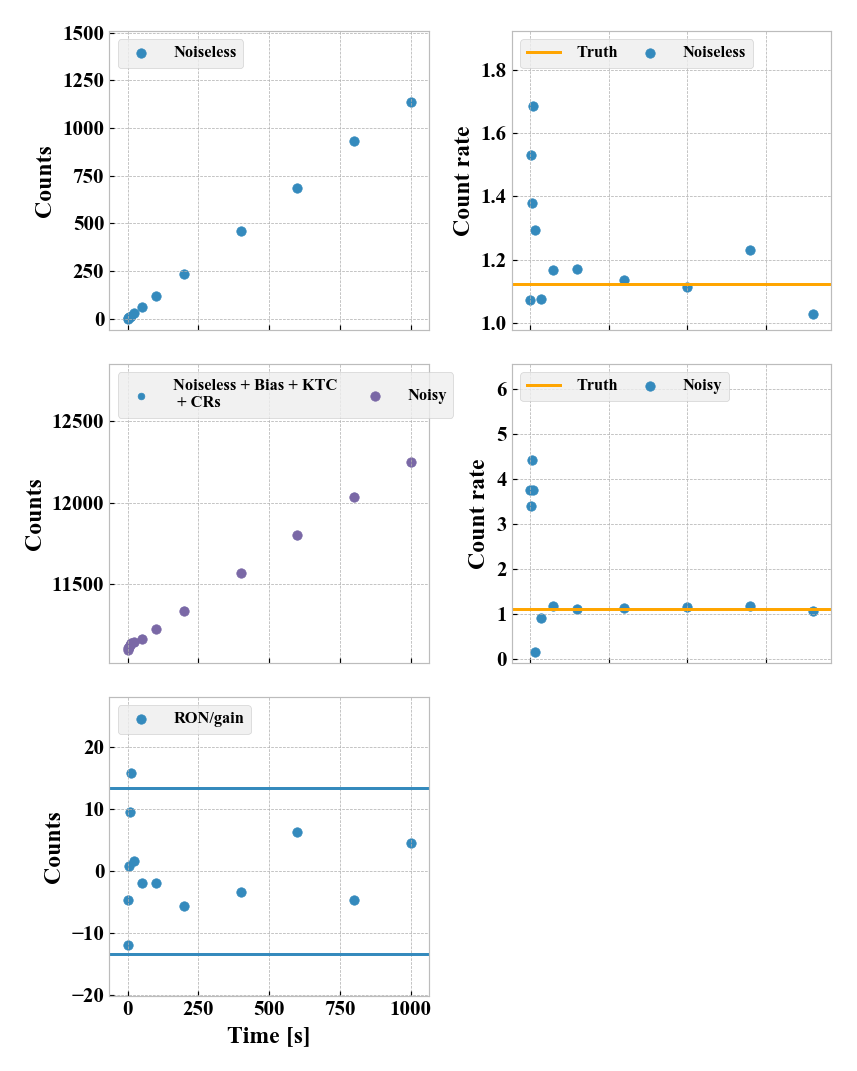

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [13]:
ix = 8886

print(gi_list[0][ix,:])
print(CR_false_positives_p[ix])
print(outerate[ix,0])
print(outerate[ix,0]/meas_list[j][0].gain)
f,ax = meas_l[ix].test_plot(plot_rate = True)

ax[2,0].axhline(2*meas_list[j][0].RON_adu)
ax[2,0].axhline(-2*meas_list[j][0].RON_adu)
